In [19]:
import numpy as np
import matplotlib.pyplot as plot
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import 

In [104]:
from momentum_prediction_util import Predictor,train,prepare_prediction_input_pulse,new_prepare_nn_input,create_nested_defaultdict,convert_dict_to_defaultdict,load_defaultdict
from time_res_util import get_compiled_NF_model


In [12]:
path_to_processed_data = '/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/data/processed_data/old_50events_high_thresh.json'
model_compile = get_compiled_NF_model()
processed_data = load_defaultdict(path_to_processed_data)
nn_input,nn_output = new_prepare_nn_input(processed_data, model_compile,batch_size = 50000)

Processing data in new_prepare_nn_input...


100%|██████████| 6/6 [00:00<00:00, 21.34it/s]


Sampling data...


100%|██████████| 17/17 [00:12<00:00,  1.34it/s]


sampling took 12.681869506835938 seconds
Reorganizing data...
reorganizing took 6.327610969543457 seconds
         2976112 function calls (2911087 primitive calls) in 19.342 seconds

   Ordered by: cumulative time
   List reduced from 286 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.703    1.703   19.343   19.343 /hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/momentum_prediction_util.py:226(new_prepare_nn_input)
       17    0.007    0.000   10.952    0.644 /hpc/group/vossenlab/rck32/ML_venv/lib64/python3.9/site-packages/normflows/core.py:286(sample)
25721/289    0.020    0.000   10.945    0.038 /hpc/group/vossenlab/rck32/ML_venv/lib64/python3.9/site-packages/torch/nn/modules/module.py:1549(_wrapped_call_impl)
25721/289    0.044    0.000   10.944    0.038 /hpc/group/vossenlab/rck32/ML_venv/lib64/python3.9/site-packages/torch/nn/modules/module.py:1555(_call_impl)
      136    0.001    0.000   10.6

In [127]:
class SiPMSignalProcessor:
    def __init__(self, 
                 sampling_rate=40e9,  # 40 GHz sampling rate
                 tau_rise=1.1e-9,       # 1.1 ns rise time
                 tau_fall=15e-9,      # 15 ns fall time
                 window=200e-9,       # 200 ns time window
                 cfd_delay=1e-9,      # 1 ns delay for CFD
                 cfd_fraction=0.3):   # 30% fraction for CFD
        
        self.sampling_rate = sampling_rate
        self.tau_rise = tau_rise
        self.tau_fall = tau_fall
        self.window = window
        self.cfd_delay = cfd_delay
        self.cfd_fraction = cfd_fraction
        
        # Time array for single pulse shape
        self.time = np.arange(0, self.window, 1/self.sampling_rate)
        
        # Generate single pulse shape
        self.pulse_shape = self._generate_pulse_shape()
    
    def _generate_pulse_shape(self):
        """Generate normalized pulse shape for a single photon"""
        shape = (1 - np.exp(-self.time/self.tau_rise)) * np.exp(-self.time/self.tau_fall)
        return shape / np.max(shape)  # Normalize
    
    def generate_waveform(self, photon_times):
        """Generate waveform from list of photon arrival times"""
        # Initialize waveform array
        waveform = np.zeros_like(self.time)
        
        # Add pulse for each photon
        for t in photon_times:
            if 0 <= t < self.window:
                idx = int(t * self.sampling_rate)
                remaining_samples = len(self.time) - idx
                waveform[idx:] += self.pulse_shape[:remaining_samples]
        
        return self.time, waveform
    
    def integrate_charge(self, waveform, integration_start=0, integration_time=100e-9):
        """Integrate charge in specified time window"""
        start_idx = int(integration_start * self.sampling_rate)
        end_idx = int((integration_start + integration_time) * self.sampling_rate)
        
        # Integrate using trapezoidal rule
        charge = np.trapezoid(waveform[start_idx:end_idx], dx=1/self.sampling_rate)
        return charge
    def constant_threshold_timing(self,waveform,threshold):
        for i in range(len(self.time)):
            if(waveform[i] > threshold):
                return self.time[i]
        return -1
        
    def apply_cfd(self, waveform, use_interpolation=False):
        """Apply Constant Fraction Discrimination to the waveform.

        Parameters:
        -----------
        waveform : numpy.ndarray
            Input waveform to process
        use_interpolation : bool, optional
            If True, use linear interpolation for sub-sample precision
            If False, return the sample index of zero crossing
            Default is True

        Returns:
        --------
        tuple (numpy.ndarray, float)
            CFD processed waveform and the zero-crossing time in seconds.
            If use_interpolation is False, zero-crossing time will be aligned
            to sample boundaries.
        """
        # Calculate delay in samples
        delay_samples = int(self.cfd_delay * self.sampling_rate)

        # Create delayed and attenuated versions of the waveform
        delayed_waveform = np.pad(waveform, (delay_samples, 0))[:-delay_samples]
        attenuated_waveform = -self.cfd_fraction * waveform

        # Calculate CFD waveform
        cfd_waveform = delayed_waveform + attenuated_waveform

        # Find all zero crossings
        zero_crossings = np.where(np.diff(np.signbit(cfd_waveform)))[0]

        if len(zero_crossings) < 2:  # Need at least two crossings for valid CFD
            return cfd_waveform, None

        # Find the rising edge of the original pulse
        pulse_start = np.where(waveform > np.max(waveform) * 0.1)[0]  # 10% threshold
        if len(pulse_start) == 0:
            return cfd_waveform, None
        pulse_start = pulse_start[0]

        # Find the first zero crossing that occurs after the pulse starts
        valid_crossings = zero_crossings[zero_crossings > pulse_start]
        if len(valid_crossings) == 0:
            return cfd_waveform, None

        crossing_idx = valid_crossings[0]

        if not use_interpolation:
            # Simply return the sample index converted to time
            crossing_time = crossing_idx / self.sampling_rate
        else:
            # Use linear interpolation for sub-sample precision
            y1 = cfd_waveform[crossing_idx]
            y2 = cfd_waveform[crossing_idx + 1]

            # Calculate fractional position of zero crossing
            fraction = -y1 / (y2 - y1)

            # Calculate precise crossing time
            crossing_time = (crossing_idx + fraction) / self.sampling_rate

        return cfd_waveform, crossing_time


    def get_pulse_timing(self, waveform, threshold=0.1):
        """Get pulse timing using CFD method with additional validation.
        
        Parameters:
        -----------
        waveform : numpy.ndarray
            Input waveform to analyze
        threshold : float
            Minimum amplitude threshold for valid pulses (relative to max amplitude)
            
        Returns:
        --------
        float or None
            Timestamp of the pulse in seconds, or None if no valid pulse found
        """
        # Check if pulse amplitude exceeds threshold
        max_amplitude = np.max(waveform)
        if max_amplitude < threshold:
            return None
            
        # Apply CFD
        _, crossing_time = self.apply_cfd(waveform)
        
        return crossing_time

In [132]:
def test(nn_input,nn_output,pixel_threshold = 5):
    processor = SiPMSignalProcessor(cfd_fraction = .3)
    waveforms = []
    time_arrs = []
    timings = []
    charges = []
    photon_time_arrs = []
    
    #note - some events do not have dictionaries in nn_input due to being empty
    #need to skip over these and condense tensor
    out_columns = ['event_idx','stave_idx','layer_idx','segment_idx','trueID','truePID','hitID','hitPID','P','Theta','Phi','strip_x','strip_y','strip_z','hit_x','hit_y','hit_z','KMU_trueID','KMU_truePID','KMU_true_phi','KMU_true_momentum_mag','KMU_endpoint_x','KMU_endpoint_y','KMU_endpoint_z','Charge1','Time1','Charge2','Time2']
    running_index = 0
    rows = []
    curr_event_num = 0
    trueID_dict = defaultdict(lambda: defaultdict(lambda: -1))
    trueID_dict_running_idx = 0
    for event_idx in tqdm(list(nn_input)):
        event_input = []
        set_output = False
        stave_keys = nn_input[event_idx].keys()
        for stave_idx in stave_keys:
#             print(f"nn_input[event_idx][stave_idx]: {nn_input[event_idx][stave_idx]}")
            layer_keys = nn_input[event_idx][stave_idx].keys()
            for layer_idx in layer_keys:
                segment_keys = nn_input[event_idx][stave_idx][layer_idx].keys()
                for segment_idx in segment_keys:
                    charge_times = np.array([[0.0,0.0],[0.0,0.0]])
                    SiPM_keys = nn_input[event_idx][stave_idx][layer_idx][segment_idx].keys()
                    set_event_details = False
                    trigger = False
                    trueID_list_len_max = -1
                    for SiPM_idx in SiPM_keys:
#                         print(f"SiPM_idx: {SiPM_idx}")
                        if(nn_output[event_idx][stave_idx][layer_idx][segment_idx][SiPM_idx][0][10] > trueID_list_len_max):
                            trueID_list_len_max = nn_output[event_idx][stave_idx][layer_idx][segment_idx][SiPM_idx][0][10]
                        photon_times = np.array(sorted(nn_input[event_idx][stave_idx][layer_idx][segment_idx][SiPM_idx])) * 10 **(-9)
                        #get relative times
                        if(len(photon_times) > 0):
                            #calculate time and charge
                            time_arr,waveform = processor.generate_waveform(photon_times)
                            timing = processor.get_pulse_timing(waveform,threshold = pixel_threshold)
                            if(timing is not None):
                                curr_charge = processor.integrate_charge(waveform)
                                
                                charges.append(curr_charge)
                                timings.append(timing)
                                time_arrs.append(time_arr)
                                waveforms.append(waveform)
                                photon_time_arrs.append(photon_times)
        curr_event_num += 1
    return (waveforms,time_arrs,timings,charges,photon_time_arrs)

In [133]:
results = test(nn_input,nn_output,pixel_threshold = 5)

100%|██████████| 8/8 [00:30<00:00,  3.78s/it]


In [134]:
waveforms, time_arrs, timings,charges,photon_time_arrs = results

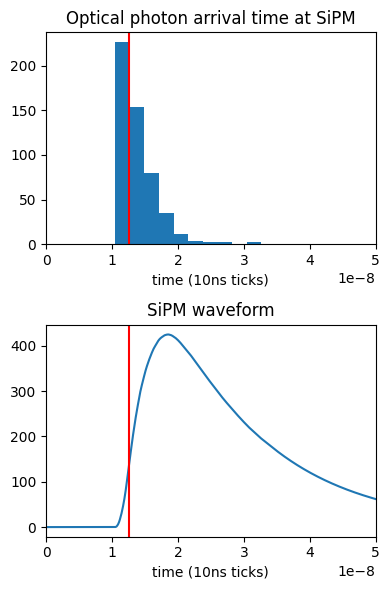

In [136]:
current_idx = 0
fig,axs = plot.subplots(2,1,figsize=(4,6))
axs[0].set_title("Optical photon arrival time at SiPM")
axs[0].hist(photon_time_arrs[current_idx])
axs[1].plot(time_arrs[current_idx],waveforms[current_idx])
axs[1].set_title("SiPM waveform")
axs[0].set_xlim(0,0.5*10**-7)
axs[1].set_xlim(0,0.5*10**-7)
axs[0].axvline(x = timings[current_idx],color = 'r')
axs[1].axvline(x = timings[current_idx],color = 'r')
axs[0].set_xlabel("time (10ns ticks)")
axs[1].set_xlabel("time (10ns ticks)")
fig.tight_layout()
fig.show()
fig.savefig("plots/SiPM/waveform_and_optical_photons.pdf")